# Задание по обработке сигналов

## Изучить:
1) Особенности обработки сигналов с точки зрения математической статистики; 

2) Применение дискретных свёрток в частототной области;

3) Анализ когерентных спектров выходного процесса с помощью библиотеку *scipy*

Приведу **список использованной литературы**:

## Квалификационная задача

Необходимо разработать, обучить и представить глубокую нейронную сеть, принимающую на вход произвольный сигнал в виде дискретной последовательности $\{s_k\}_{k = 1}^{1024}$, $s \in \Re$, $t_{k + 1} - t_k = \tau$, и выдающую на выходе оценку **power spectral density (dB)** в виде дискретной последовательности $\{g_k\}_{k = 0}^{512}$. Обучающее и тестовые множества должны иметь нулевое среднее и единичную дисперсию.

In [4]:
import numpy as np
import scipy.signal as signal
import scipy.stats as sts
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, Lambda
from keras.models import Sequential

In [5]:
class generator:
    def __init__(self, parameters):
        self.__len__ = 1024
        self.sgnl_type, self.tmp = parameters
        self.signal_ = np.zeros(self.__len__); self.t = np.linspace(0, self.__len__, self.__len__) 
        """
        signal types: 
        determined:
            -- periodic signal with frequency f (f = 1 / T where T is period) and amplitude A; ph is #pi-fold.
            -- aperiodic signal with main frequency f and time tau;
            -- non-periodic signals like exponent
        random:
            -- stationary -- gaussian or bernoulli 
            -- non-stationary -- full random
        """
        if self.sgnl_type == "periodic":
            self.A, self.f, self.ph = self.tmp
            self.signal_ = self.A * np.sin(2 * np.pi * self.f * self.t / self.__len__  + np.pi * self.ph)
        
        elif self.sgnl_type == "aperiodic":
            self.A, self.f, self.ph, self.tau = self.tmp
            self.signal_ = self.A * np.sin(2 * np.pi * self.f * self.t / self.__len__ + np.pi * self.ph) * np.exp(- self.t/self.tau)

        elif self.sgnl_type == "non-periodic":
            self.A, self.tau = self.tmp
            self.signal_ = self.A * np.exp(- self.t/self.tau)

        elif self.sgnl_type == "stationary":
            self.A = self.tmp
            self.signal_ = self.A * sts.norm.rvs(size = self.__len__)
        elif self.sgnl_type == "non-stationary":
            self.A = self.tmp
            self.w = 0.23456
            self.signal_ = self.A * (self.w * sts.norm.rvs(size = self.__len__) + (1 - self.w) * sts.bernoulli.rvs(p = self.w, size = self.__len__))
        elif self.sgnl_type == "mixed":
            self.A, self.f, self.ph, self.tau = self.tmp
            self.w = 0.01
            self.signal_ = self.A * self.w * sts.norm.rvs(size = self.__len__) + \
             (1 - self.w) * self.A * np.sin(2 * np.pi * self.f * self.t / self.__len__  + np.pi * self.ph) * np.exp(- self.t/self.tau)

    def _make_signal(self):
      # print("... \n")
      return self.signal_, signal.periodogram(self.signal_)[1]

### Шаг первый: генерация дискретных последовательностей

Выделим основные типы:
* детерминированные
    1. периодические 
    2. апериодические
* случайные
    1. стационарные (для простоты: белый шум, "почти" периодическая последовательность
    2. нестационарные (TODO: пока белиберда)
* также я сделал микс-сигнал из зашумлённого апериодического
    
Сгенерируем датасет,
по 1000 семплов сигналов каждого видео.


In [6]:
def get_dataset(n_samples = 2000):
    signal_ = []
    for _ in range(n_samples):
        A = random.uniform(0.0, 20.0)
        f = random.uniform(0.01, 100.0)
        ph = random.uniform(-np.pi /2 , np.pi /2)
        tau = random.uniform(0.1, 5.0)
        signal_.append(generator(("periodic", (A, f, ph)))._make_signal())
        signal_.append(generator(("aperiodic", (A, f, ph, tau)))._make_signal())
        signal_.append(generator(("non-periodic", (A, tau)))._make_signal())
        signal_.append(generator(("stationary", A))._make_signal())
        signal_.append(generator(("non-stationary", A))._make_signal())
        signal_.append(generator(("mixed", (A, f, ph, tau)))._make_signal())
    print("generating dataset... \n")
    X, y =  np.array([a[0] for a in signal_]), np.array([a[1] for a in signal_])
    a, b = X.shape[0], X.shape[1]
    return X.reshape((a, b, 1)), y

### Шаг второй: PSD и преобразование Фурье



[Основные понятия](https://www.sciencedirect.com/topics/engineering/power-spectral-density):
* Средняя мощность сигнала: 
\begin{align} 
P = \lim_{T \to \infty} \frac{1}{T} \int^{T}_{0} |x(t)|^2 dt
\end{align}

* Пусть $\hat{x}(\xi) = \frac{1}{\sqrt{T}} \int_0^{T} x(t) e^{-i \xi t} dt$ $-$ преборазование Фурье сигнала, заданного на финитном промежутке $[0;T]$

Тогда зададим спектральную мощность как
\begin{align} 
S(\omega) = \lim_{T \to \infty} \mathbf{E} |\hat{x}^2(\omega)|, \\
R(\tau) = \mathbf{E}[ X(t) X(t + \tau)], \\
\rightarrow S(\omega) = \int_{-\infty}^{\infty} R(\tau) e^{-i \omega \tau} d \tau = \hat{R}(\omega)
\end{align}

Здесь перечислены всего лишь основные законы и выкладки. Я воспользовался определением матожидание через интеграл по мере Лебега и теоремой Винера-Хинчина: **плотность спектральной мощности - это преобразование Фурье от автокорреляционной функции**.

В моей ничтожной работе будет играть основную роль сигнал *дискретного времени*, т.е. являющийся последовательностью отсчётов. Вводя следующие обозначения:

\begin{align} 
1 \leq n \leq N = 1024, \\
x_n = x(n \Delta t), \\
T = N \Delta t, -
\end{align}

характерный период наблюдения сигнала, получаем формулу для плотности спектральной мощности в следующем виде:

\begin{align} 
S(\omega) = \frac{(\Delta t)^2 } {T} | \sum_{n = 1}^{N} x_n e^{-i \omega n \Delta t} |^2
\end{align}
Получилось ДВПФ исходного сигнала, а для случайных величин штука под модулем зовётся *периодограммой*, реализуемой методом 'scipy.signal.periodogram', которая работает очень даже неплохо.

Таким образом, необходимой частью моей работы становится проведение с помощью нейросети преобразования Фурье исходного сигнала, носитель которого ограничен. Попробуем реалзовать данную возможность при помощи следующей архитектуры идейно взято [отсюда](https://benanne.github.io/2014/05/12/fft-convolutions-in-theano.html), наверное:

1. Используем линеные операции, чтобы сохранить линейность преобразования
2. Никакого вектора сдвига, так как это не нужно
3. Используем 1D СNN, Фурье-свёртки


In [9]:
def evaluate_model(X_train, y_train, X_valid, y_valid):
    verbose, epochs, batch_size = 1, 500, 200
  
    model = Sequential([Input(shape = (1024, 1)), 
                        Flatten(),
                        Lambda(lambda v: tf.cast(tf.signal.rfft(tf.cast(v, dtype = tf.float32)), tf.float32)),
                        Dense(513, use_bias = False),
                        Dropout(0.25),
                        Dense(513, use_bias = False)])
  
    model.compile(loss = 'mean_absolute_error', optimizer = 'adadelta')
    # fit network
    print(model.summary())
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), 
                        epochs = epochs, batch_size = batch_size, verbose = verbose)
   
    return model, history

Давайте протестируем модель случайной тестовой выборке и отобразим необходимые графики.

generating dataset... 

generating dataset... 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 513)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 513)               263169    
_________________________________________________________________
dropout_1 (Dropout)          (None, 513)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 513)               263169    
Total params: 526,338
Trainable params: 526,338
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
600/600 [==============================] - 3s 5ms

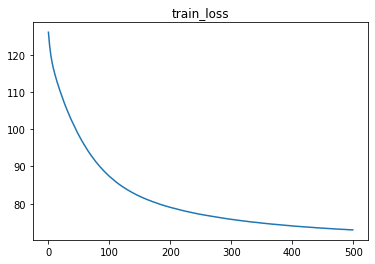

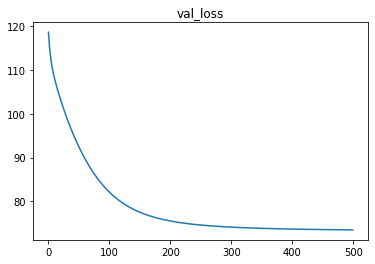

generating dataset... 

1/1 [==============================] - 0s 2ms/step - loss: 61.6645
61.66450119018555


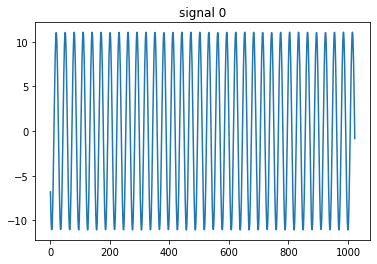

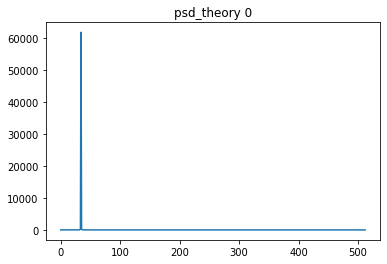

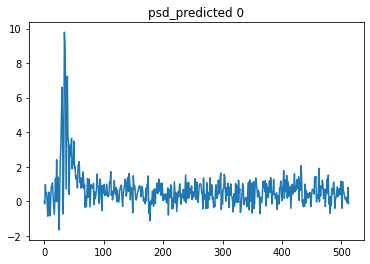

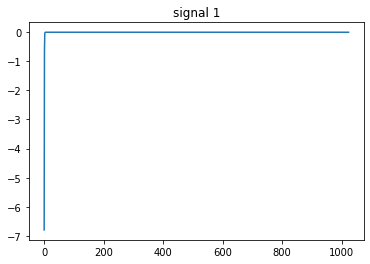

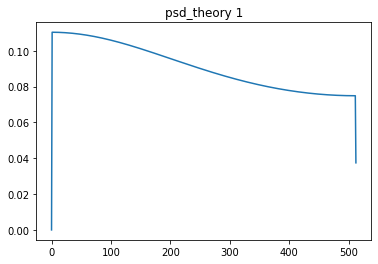

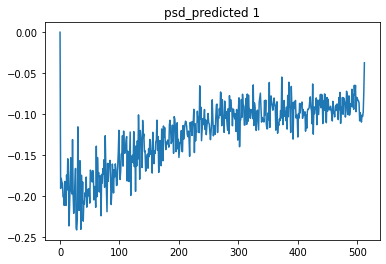

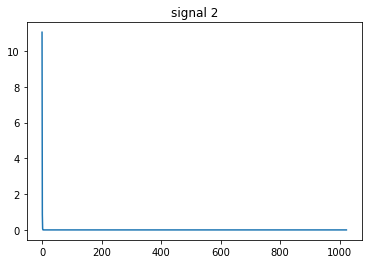

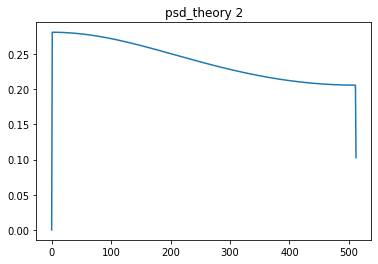

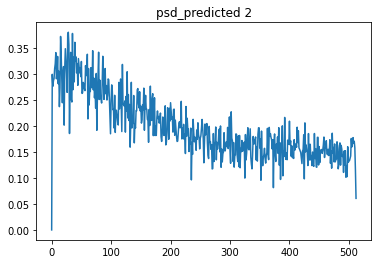

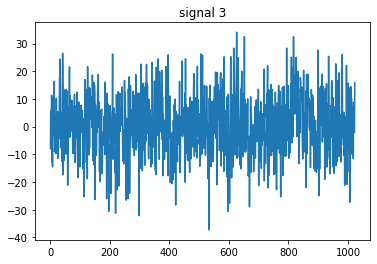

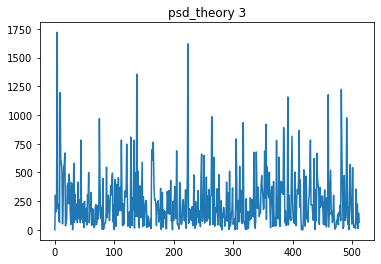

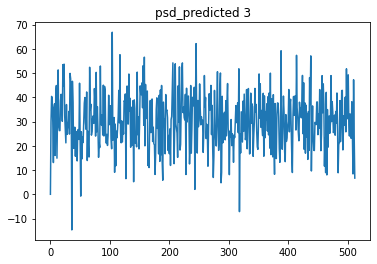

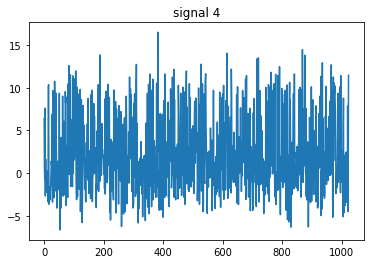

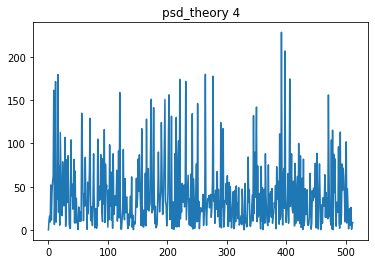

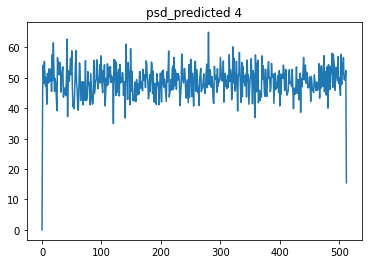

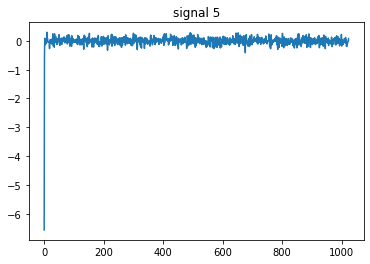

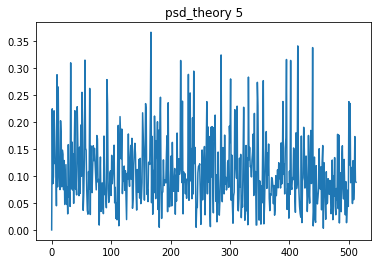

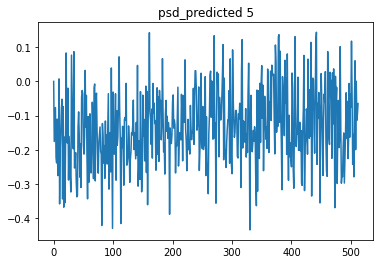

In [10]:
def __main__(): 
    np.random.seed(0)
    X_train, y_train = get_dataset(20000)
    X_valid, y_valid = get_dataset(5000)
    model, history = evaluate_model(X_train, y_train, X_valid, y_valid)
    plt.plot(history.history['loss']); plt.title('train_loss'); plt.show()
    plt.plot(history.history['val_loss']); plt.title('val_loss'); plt.show()
    X_test, y_test = get_dataset(1)
    y_pred = model.predict(X_test)
    print(model.evaluate(X_test, y_test))
    for ind in range(len(y_test)):
      plt.plot(X_test[ind]); plt.title('signal ' + str(ind)); plt.show()
      plt.plot(y_test[ind]); plt.title('psd_theory ' + str(ind)); plt.show()
      plt.plot(y_pred[ind]); plt.title('psd_predicted '+ str(ind)); plt.show()


if __name__ == "__main__":
    __main__()